In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import imageio #这个东西是用来读取tiff图片得
import seaborn as sns
import time   #时间相关的

plt.style.use('classic')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
path = os.path.abspath(os.path.dirname(os.getcwd()) + os.path.sep + ".")
raw_data_point = path+'\LSM\PointData'     #这个是用来读取点数据路径得
raw_data_raster = path+'\LSM\RasterData2'   #这个是用来读取像素数据得
Picture_result = path+'\LSM\Picture'   #这个是用来读取像素数据得


#本处为载入将要运用的全部模型
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import accuracy_score,mean_squared_error,roc_auc_score,roc_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 随机种子42     5折训练
SEED = 42 
NFOLDS = 5
KF = KFold(n_splits= NFOLDS,shuffle=True,random_state=SEED)

In [2]:
All_data = pd.read_csv('Raster10m.csv',encoding='utf-8',delimiter=',')
print('Raw shape of Px1 is',len(All_data))
print('(Po1) No HLS samples:',All_data['A0'].value_counts()[0],'HLS samples:',All_data['A0'].value_counts()[1])
print('(Po1) No ELS samples:',All_data['A1'].value_counts()[0],'ELS samples:',All_data['A1'].value_counts()[1])
print("-------------------------------------------------------")

PointReadtarget = ['\Point1.txt','\Point2.txt','\Point3.txt']
PointDataName = ['All_dataPo1','All_dataPo2','All_dataPo3']

for i,name in enumerate(PointDataName):
    globals()[name] = pd.read_csv(raw_data_point+PointReadtarget[i],encoding='ascii',delimiter=',')
    globals()[name].replace(-9999,np.nan,inplace=True)
    old_length = len(globals()[name])
    globals()[name].dropna(axis=0, how='any', inplace=True)
    new_length = len(globals()[name])
    print('Raw shape of Dataset',name,'is',old_length,'New:',new_length,'delete',old_length-new_length,'rows')
    globals()[name].replace({'A0': 1, 'A1': 1}, 0,inplace=True)
    globals()[name].replace({'A0': 2, 'A1': 2}, 1,inplace=True) 
    print(name,': No HLS samples:',globals()[name]['A0'].value_counts()[0],'HLS samples:',globals()[name]['A0'].value_counts()[1])
    print(name,': No HLS samples:',globals()[name]['A1'].value_counts()[0],'HLS samples:',globals()[name]['A1'].value_counts()[1])
    print("-------------------------------------------------------")


Raw shape of Px1 is 11130632
(Po1) No HLS samples: 10450944 HLS samples: 679688
(Po1) No ELS samples: 10765038 ELS samples: 365594
-------------------------------------------------------
Raw shape of Dataset All_dataPo1 is 500000 New: 493441 delete 6559 rows
All_dataPo1 : No HLS samples: 463089 HLS samples: 30352
All_dataPo1 : No HLS samples: 477032 HLS samples: 16409
-------------------------------------------------------
Raw shape of Dataset All_dataPo2 is 121534 New: 120561 delete 973 rows
All_dataPo2 : No HLS samples: 82922 HLS samples: 37639
All_dataPo2 : No HLS samples: 98779 HLS samples: 21782
-------------------------------------------------------
Raw shape of Dataset All_dataPo3 is 16162 New: 16042 delete 120 rows
All_dataPo3 : No HLS samples: 14006 HLS samples: 2036
All_dataPo3 : No HLS samples: 9868 HLS samples: 6174
-------------------------------------------------------


In [3]:
# 用来减少内存使用的方程
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))  
    for col in df.columns:
        col_type = df[col].dtype    
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
All_data = reduce_mem_usage(All_data)

Memory usage of dataframe is 1868.24 MB
Memory usage after optimization is: 435.22 MB
Decreased by 76.7%


## Minimum and maximum process (0.1-0.9)

In [5]:
LSM_Y =['A0']
LSM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
ESM_Y = ['A1']
ESM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A13','A14','A15','A16','A17','A18','A19','A20']

y_hls =  All_data[LSM_Y] ; y_hlsp1 = All_dataPo1[LSM_Y] ; y_hlsp2 = All_dataPo2[LSM_Y] ; y_hlsp3 = All_dataPo3[LSM_Y]
x_hls =  All_data[LSM_X] ; x_hlsp1 = All_dataPo1[LSM_X] ; x_hlsp2 = All_dataPo2[LSM_X] ; x_hlsp3 = All_dataPo3[LSM_X]

y_els =  All_data[ESM_Y] ; y_elsp1 = All_dataPo1[ESM_Y] ; y_elsp2 = All_dataPo2[ESM_Y] ; y_elsp3 = All_dataPo3[ESM_Y]
x_els =  All_data[ESM_X] ; x_elsp1 = All_dataPo1[ESM_X] ; x_elsp2 = All_dataPo2[ESM_X] ; x_elsp3 = All_dataPo3[ESM_X]

In [6]:
# 对输入模型进行标准化转化
from sklearn.preprocessing import StandardScaler,MinMaxScaler
print("-----------------------before the preprocessing--------------------------------")
Max_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_max_
print('The maximun of each columns',Max_Sca)
Min_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_min_
print('The minimun of each columns',Min_Sca)


print("-----------------------After the preprocessing--------------------------------")
column_index = x_els.columns
x_els_values = MinMaxScaler(feature_range=(0.1,0.9)).fit_transform(x_els.values)
x_els =pd.DataFrame(x_els_values, columns = column_index) 


Max_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_max_
print('The maximun of each columns',Max_Sca_after)
Min_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_els).data_min_
print('The minimun of each columns',Min_Sca_after)

print("-----------------------preprocessing  Pointdata--------------------------------")

for i, column_name in enumerate(ESM_X):
    x_elsp1[column_name] = x_elsp1[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_elsp2[column_name] = x_elsp2[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_elsp3[column_name] = x_elsp3[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    print('Factor :',column_name,'Finished')

-----------------------before the preprocessing--------------------------------
The maximun of each columns [2.0000000e+01 1.7000000e+01 1.2000000e+01 1.0025000e+03 7.2187500e+01
 3.6000000e+02 5.4187500e+01 1.0728000e+04 9.0000000e+03 1.8850000e+03
 3.3250000e+02 6.5500000e+02 8.1400000e+02 8.6200000e+02 1.3560000e+03
 6.3554688e+00 3.9296000e+04 3.6000000e+02]
The minimun of each columns [  1.         1.         1.         0.         0.        -1.
 -64.375      0.         0.         0.       215.625    123.5625
 106.        50.375    138.125      4.234375   0.         0.      ]
-----------------------After the preprocessing--------------------------------
The maximun of each columns [0.9        0.90000004 0.9        0.90000004 0.90000004 0.9
 0.90000004 0.90000004 0.90000004 0.90000004 0.9        0.90000004
 0.90000004 0.90000004 0.90000004 0.9000001  0.90000004 0.90000004]
The minimun of each columns [0.1        0.1        0.1        0.1        0.1        0.1
 0.09999999 0.1        

In [8]:
def get_oof(clf, X_Train, y_Train, X_Test):
    oof_train = np.zeros((len(X_Train),))
    oof_test = np.zeros((len(X_Test),))
    oof_test_skf = np.empty((NFOLDS, len(X_Test)))
    X_Train.index = range(len(X_Train))
    y_Train.index = range(len(y_Train))
    for i, (train_index, test_index) in enumerate(KF.split(X_Train)):
        X_tr = X_Train.loc[train_index]
        y_tr = y_Train.loc[train_index]
        X_te = X_Train.loc[test_index]

        clf.fit(X_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(X_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(X_Test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [11]:
final_para2 =[{'penalty': 'l2',
              'random_state': 42,
              'verbose': 0,
              'n_jobs': 8,
              'C': 0.001,
              'solver': 'sag',
              'max_iter': 100,
              'tol': 0.1},
             {'criterion': 'gini',
              'splitter': 'best',
              'random_state': 42,
              'max_depth': 4,
              'max_features': 0.1,
              'min_samples_split': 2},
             {'weights': 'uniform',
              'algorithm': 'auto',
              'metric': 'minkowski',
              'n_neighbors': 100},
             {'solver': 'adam',
              'learning_rate': 'adaptive',
              'max_iter': 2000,
              'batch_size': 200,
              'early_stopping': True,
              'activation': 'logistic',
              'hidden_layer_sizes': (256,)},
             {'solver': 'adam',
              'learning_rate': 'adaptive',
              'activation': 'logistic',
              'max_iter': 2000,
              'batch_size': 200,
              'early_stopping': True,
              'hidden_layer_sizes': (128, 64, 32)},
             {'criterion': 'gini',
              'random_state': 42,
              'max_depth': 3,
              'max_features': 0.1,
              'min_samples_split': 2,
              'n_estimators': 400}]

In [12]:
LR_Para2 =final_para2[0]
DT_Para2 = final_para2[1]
KNN_Para2 = final_para2[2]
ANN_Para2 = final_para2[3]
MLP_Para2 = final_para2[4]
RF_Para2 =  final_para2[5]

def get_models2():
    LR_ELS_2 = LogisticRegression(**LR_Para2)
    DT_ELS_2 =DecisionTreeClassifier(**DT_Para2)
    KNN_ELS_2= KNeighborsClassifier(**KNN_Para2)
    ANN_ELS_2 = MLPClassifier(**ANN_Para2)
    MLP_ELS_2 = MLPClassifier(**MLP_Para2)
    RF_ELS_2 = RandomForestClassifier(**RF_Para2)
    
    models ={'LR_ELS': LR_ELS_2,
             'DT_ELS': DT_ELS_2,
             'KNN_ELS':KNN_ELS_2,
             'ANN_ELS':ANN_ELS_2,
             'MLP_ELS':MLP_ELS_2,
             'RF_ELS':RF_ELS_2,
            }
    
    return models

In [13]:
aucresult2 = []
models = get_models2()
X_Train = x_elsp2
X_Test = x_elsp1

y_Train =pd.DataFrame(y_elsp2) 
y_Test = pd.DataFrame(y_elsp1) 


Stacking_Train2 = pd.DataFrame(columns = models,index =X_Train.index)
Stacking_Test2 = pd.DataFrame(columns = models,index =X_Test.index)


for m in models:
    M1_oof_train, M1_oof_test = get_oof(models[m], X_Train, y_Train, X_Test)
    print(m,"Model K-Fold AUC Train score: %.4f  " % roc_auc_score(y_Train,pd.DataFrame(M1_oof_train,index=y_Train.index)),end='')
    print(m,"Model K-Fold AUC Test score: %.4f" % roc_auc_score(y_Test['A1'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    aucresult2.append(roc_auc_score(y_Test['A1'],pd.DataFrame(M1_oof_test,index=y_Test.index)))
    Stacking_Train2[m] =  M1_oof_train.ravel()
    Stacking_Test2[m] = M1_oof_test.ravel()

LR_ELS Model K-Fold AUC Train score: 0.9238  LR_ELS Model K-Fold AUC Test score: 0.9153
DT_ELS Model K-Fold AUC Train score: 0.9171  DT_ELS Model K-Fold AUC Test score: 0.9043
KNN_ELS Model K-Fold AUC Train score: 0.9575  KNN_ELS Model K-Fold AUC Test score: 0.9546
ANN_ELS Model K-Fold AUC Train score: 0.9347  ANN_ELS Model K-Fold AUC Test score: 0.9279
MLP_ELS Model K-Fold AUC Train score: 0.9375  MLP_ELS Model K-Fold AUC Test score: 0.9355
RF_ELS Model K-Fold AUC Train score: 0.9396  RF_ELS Model K-Fold AUC Test score: 0.9356


In [14]:
Stacking = LogisticRegression().fit(Stacking_Train2,y_Train)
print('Bagging training AUC score: %.4f' % roc_auc_score(y_Train,Stacking_Train2.mean(axis=1)),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A1'],Stacking_Test2.mean(axis=1)))
print("LR stacking training AUC score: %.4f" % roc_auc_score(y_Train,Stacking.predict_proba(Stacking_Train2)[:,1]),end='')
print("  test AUC score: %.4f" % roc_auc_score(y_Test['A1'],Stacking.predict_proba(Stacking_Test2)[:,1]))

Bagging training AUC score: 0.9474  test AUC score: 0.9429
LR stacking training AUC score: 0.9573  test AUC score: 0.9548


In [15]:
ModelResult3 = Stacking_Train2.copy()
ModelResult3['Bagging2'] = Stacking_Train2.mean(axis=1)
ModelResult3['Stacking2'] =Stacking.predict_proba(Stacking_Train2)[:,1]

ModelResult4 = Stacking_Test2.copy()
ModelResult4['Bagging2'] = Stacking_Test2.mean(axis=1)
ModelResult4['Stacking2'] =Stacking.predict_proba(Stacking_Test2)[:,1]

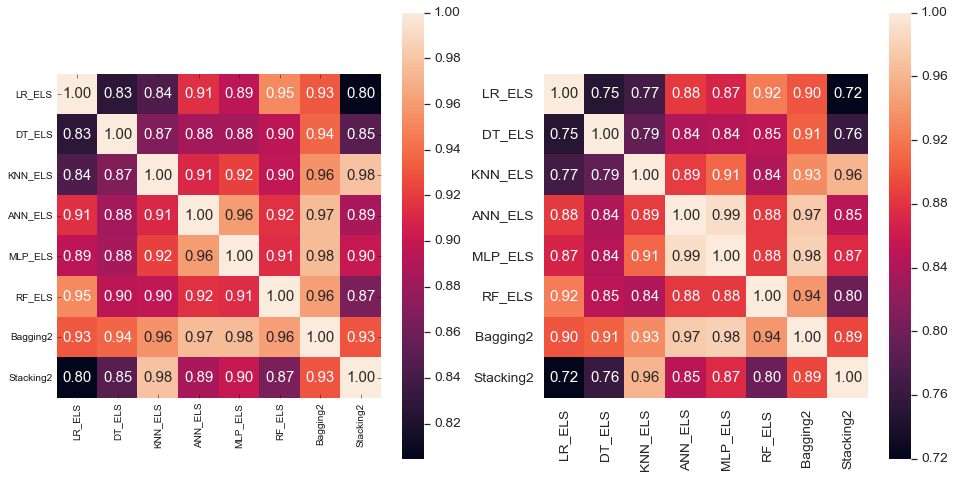

In [16]:
corrmat4= ModelResult3.corr()
corrmat5= ModelResult4.corr()

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat4,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([ModelResult3.shape[1], 0]);

plt.subplot(1,2,2)


sns.set(font_scale=1.25)

hm = sns.heatmap(corrmat5,cbar=True,square=True,annot=True,fmt=".2f");
hm.set_ylim([ModelResult4.shape[1], 0]);

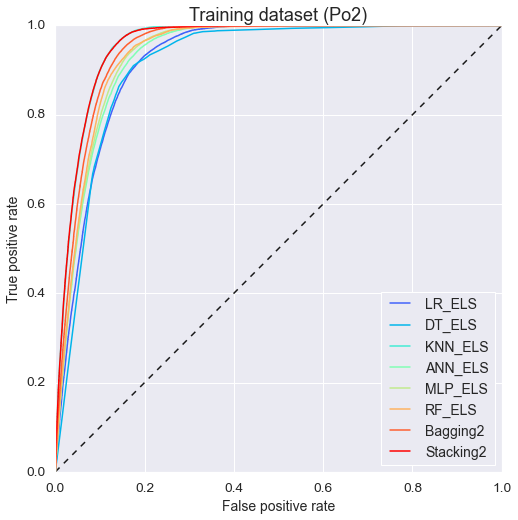

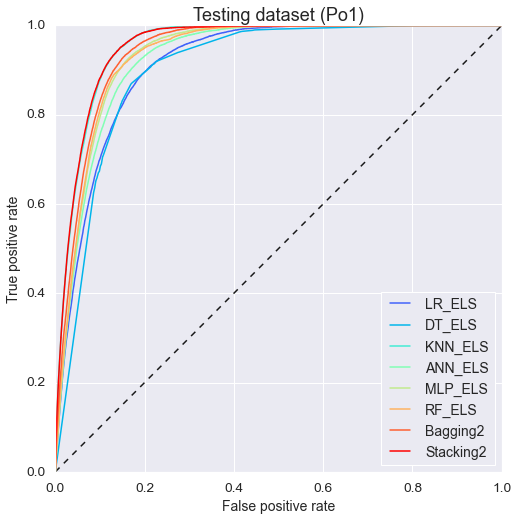

In [18]:
def plot_roc_curve(y_Test, P_learners, labels, title = 'Training dataset (Po2)'):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_learners.shape[1] + 1)]
    
    for i in range(P_learners.shape[1]):
        p = P_learners[:, i]
        fpr, tpr, _ = roc_curve(y_Test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

        
    plt.xlabel('False positive rate',fontsize=14)
    plt.ylabel('True positive rate',fontsize=14)
    plt.title(title,fontsize=18)
    plt.legend(loc = 'lower right',title_fontsize=14,fontsize=14)
    plt.show()
    
plot_roc_curve(y_Train, ModelResult3.values, list(ModelResult3.columns),title = 'Training dataset (Po2)')
plot_roc_curve(y_Test, ModelResult4.values, list(ModelResult4.columns),title = 'Testing dataset (Po1)')

In [20]:
def plot_map_point(Data,Labelvalues,Labletext,ColorLabel,var='A1',titles='Susceptibility map'):
    
    plt.figure(figsize=(15,10))
    
    for i in range(len(Labelvalues)):
        temp = Data[Data[var]==Labelvalues[i]]
        plt.scatter(temp['X'],temp['Y'],marker='o',color =ColorLabel[i] ,label=Labletext[i],s=0.5)
    
    plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
    plt.xlim(141.7,142.4)

    plt.ylim(42.5,43.0)
    plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);

    plt.legend(loc = 'lower right',fontsize=16);
    plt.title(titles+' susceptibility map',fontsize=16)
    plt.show()

In [22]:
ModelResult4['X'] = All_dataPo1['XCoord']
ModelResult4['Y'] = All_dataPo1['YCoord']
ModelResult4['HLS'] = All_dataPo1['A0']
ModelResult4['ELS'] = All_dataPo1['A1']

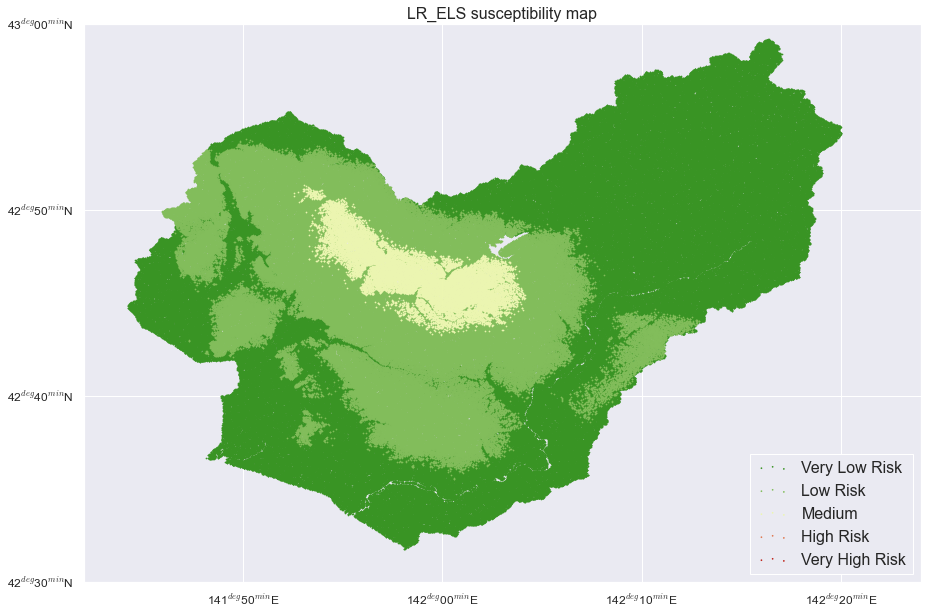

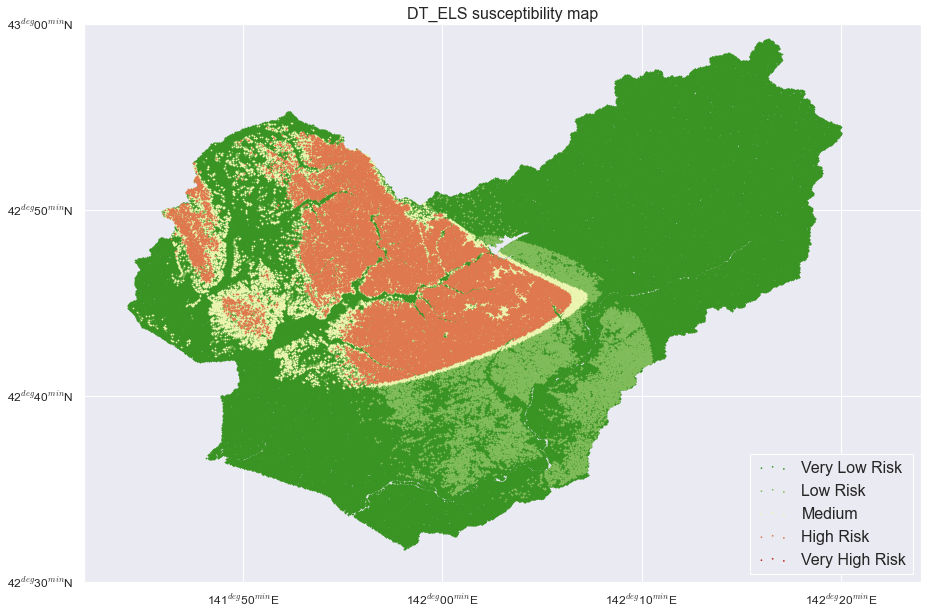

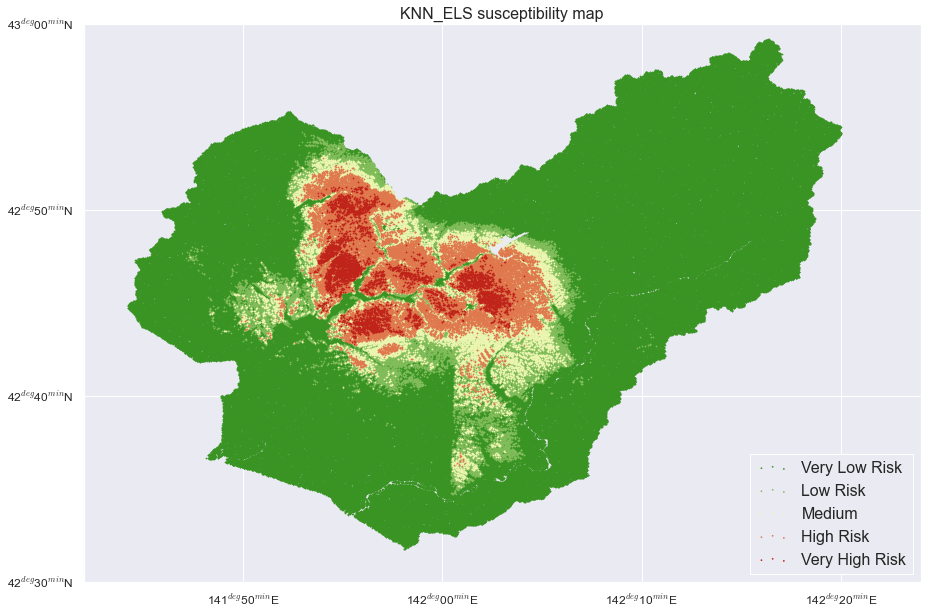

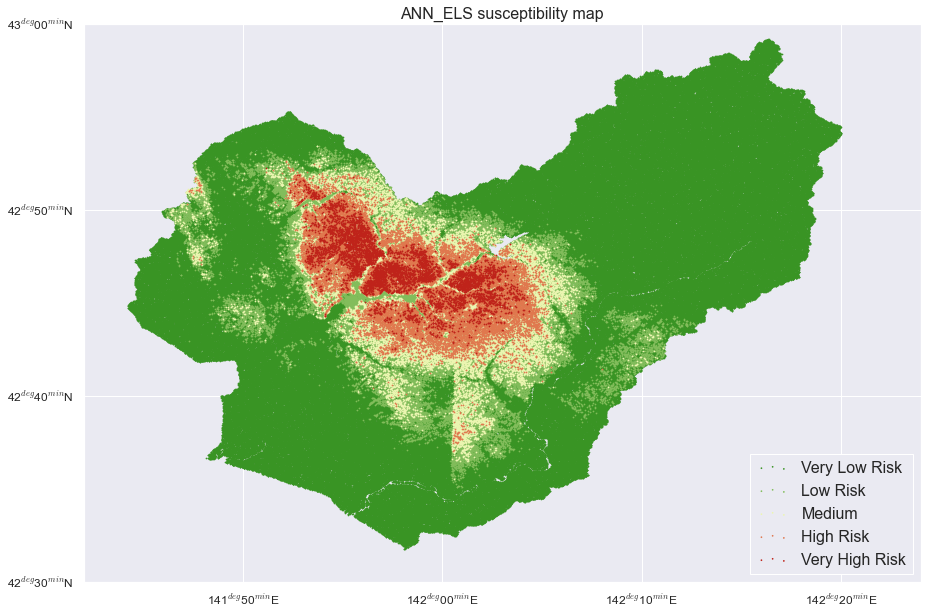

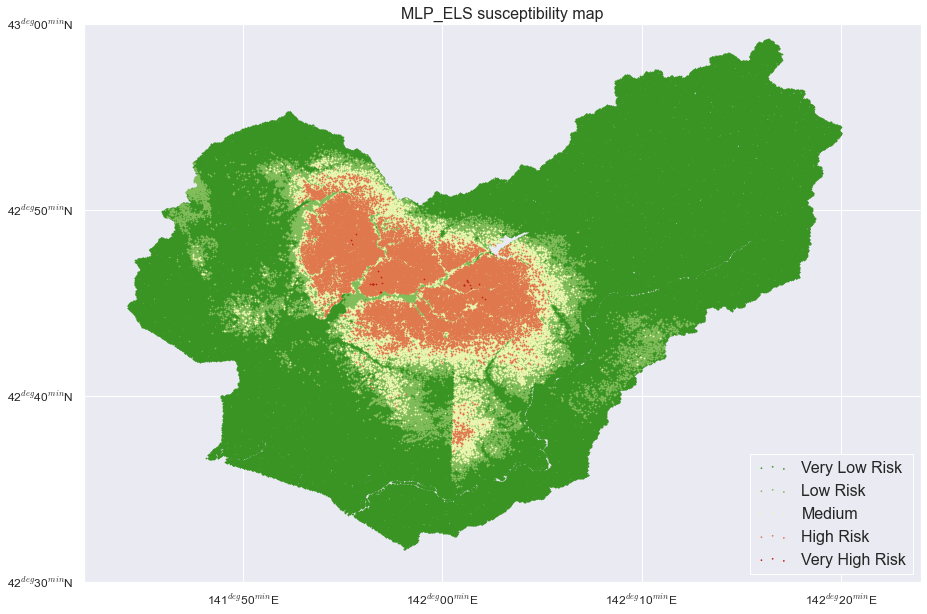

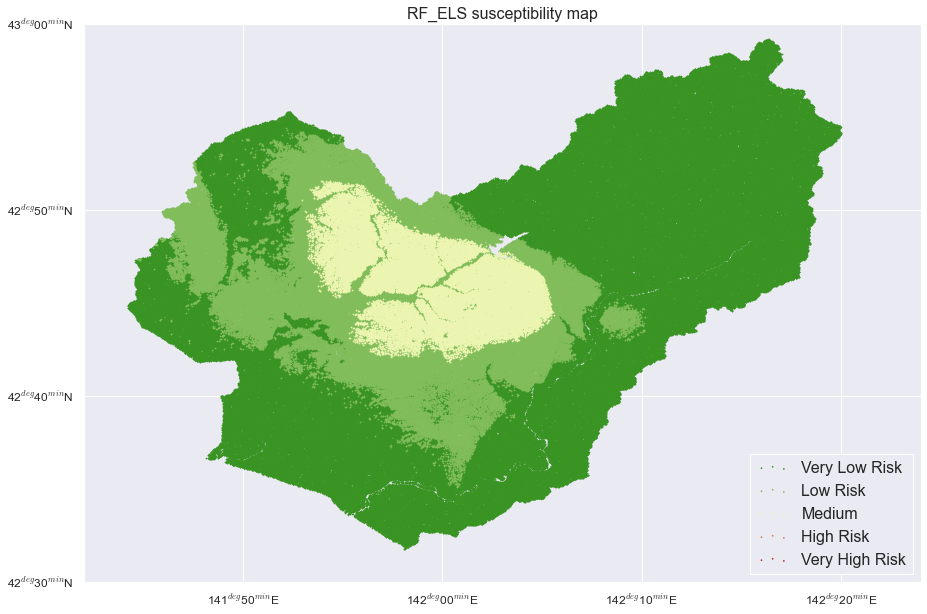

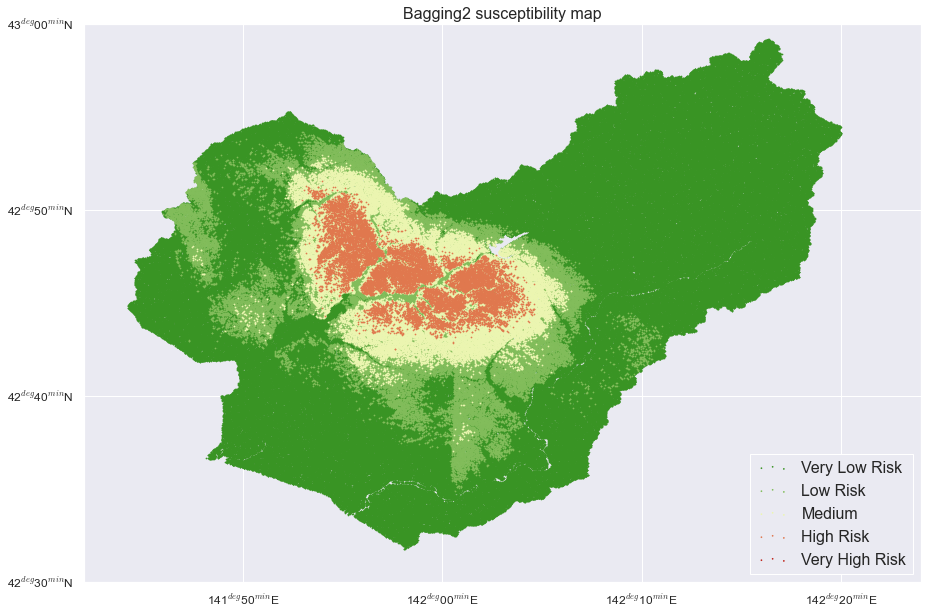

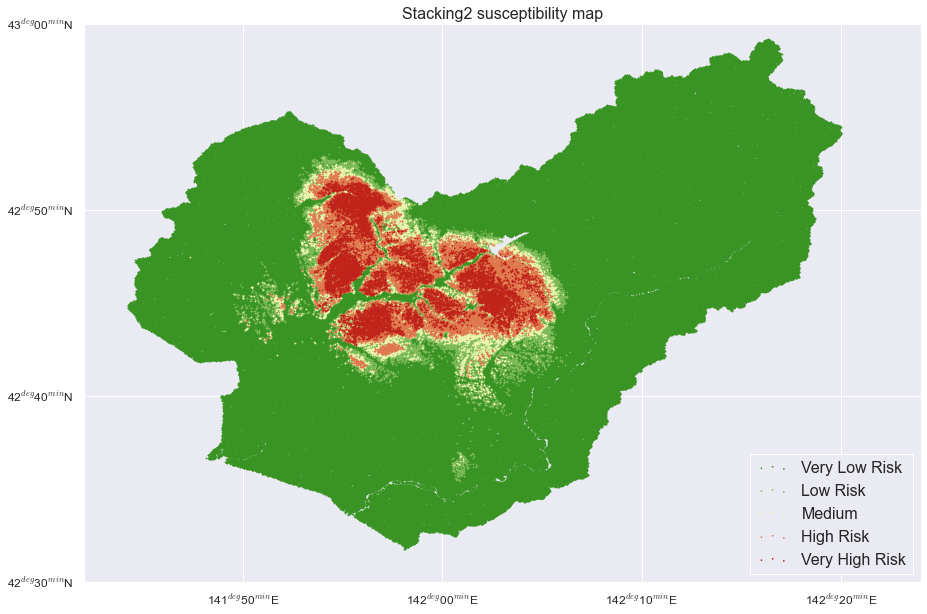

In [23]:
Labelvalues = ['Very Low Risk','Low Risk','Medium','High Risk','Very High Risk']
ColorLabel = ['#399424','#82BD5B','#ECF6B1','#E0784E','#BF231A']
bins = [-0.1,0.2,0.4,0.6,0.8,1.0]
TargetModel2 = ['LR_ELS','DT_ELS','KNN_ELS','ANN_ELS','MLP_ELS','RF_ELS','Bagging2','Stacking2']

for i in TargetModel2:
    ModelResult4['ELS_Risk'] = pd.cut(ModelResult4[i],bins,labels=['Very Low Risk','Low Risk',
                                                                      'Medium','High Risk','Very High Risk']) 

    plot_map_point(ModelResult4,Labelvalues,Labelvalues,ColorLabel,var='ELS_Risk',titles = i)